# Deep Learning Experiments

Trying Deep Learning on the house prices dataset

## Create a preprocessing pipeline

Recreate the preprocessing used in previous notebooks

In [1]:
import os
import platform
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Check which platform is running the notebook
if platform.system() == 'Windows':
    PROJECT_PATH = "\\".join(os.getcwd().split('\\')[:-1])
else:
    # Assuming a Unix based platform
    PROJECT_PATH = "/".join(os.getcwd().split('/')[:-1])

DATA_PATH = os.path.join(PROJECT_PATH, 'data')
TRAIN_DATA_PATH = os.path.join(DATA_PATH, 'train.csv')

train_data = pd.read_csv(TRAIN_DATA_PATH)
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
numeric_cols = [
    'MSSubClass',
    'LotFrontage',
    'LotArea',
    'YearBuilt',
    'YearRemodAdd',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    '1stFlrSF',
    '2ndFlrSF',
    'LowQualFinSF',
    'GrLivArea',
    'BsmtFullBath',
    'FullBath',
    'HalfBath',
    'BedroomAbvGr',
    'TotRmsAbvGrd',
    'Fireplaces',
    'GarageYrBlt',
    'GarageCars',
    'GarageArea',
    'WoodDeckSF',
    'OpenPorchSF',
    'EnclosedPorch',
    '3SsnPorch',
    'ScreenPorch',
    'MiscVal',
    'MoSold',
    'YrSold'
]

ordinal_cols_pt1 = [
    'BsmtQual',
    'BsmtExposure',
    'BsmtFinType1',
    'FireplaceQu'
]

ordinal_cols_pt2 = [
    'LotShape',
    'ExterQual',
    'BsmtQual',
    'BsmtExposure',
    'BsmtFinType1',
    'HeatingQC',
    'KitchenQual',
    'FireplaceQu'
]

categorical_cols = [
    'MSZoning',
    'LandContour',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Foundation',
    'GarageType',
    'GarageFinish'
]

In [3]:
from sklearn.base import TransformerMixin

class CreateNewFeatures(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['BeenRemodelled'] = (X.YearBuilt == X.YearRemodAdd)
        X['HasGarage'] = X.GarageType.isna().astype(int)
        X['OverallRating'] = (X.OverallCond + X.OverallQual) / 2
        return X
    
    @staticmethod
    def get_features():
        return ['BeenRemodelled', 'HasGarage', 'OverallRating']

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

ordinal_pipeline_pt1 = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='None')),
    ('encoder', OrdinalEncoder())
])

ordinal_pipeline_pt2 = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

categorical_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='None')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])


numeric_pipeline = Pipeline([
    ('gen', CreateNewFeatures()),
    ('garage_prep', ColumnTransformer([
        ('garage_fill', SimpleImputer(strategy='constant', fill_value=0), ['GarageYrBlt']),
        ('numeric_fill', SimpleImputer(strategy='median'), numeric_cols)
    ])),
    ('scaler', MinMaxScaler())
])

In [5]:
from sklearn.pipeline import FeatureUnion

processing_pipeline = FeatureUnion([
    ('numeric', numeric_pipeline),
    ('processing', ColumnTransformer([
        ('ordinal_pt1', ordinal_pipeline_pt1, ordinal_cols_pt1),
        ('ordinal_pt2', ordinal_pipeline_pt2, ordinal_cols_pt2),
        ('categorical', categorical_pipeline, categorical_cols)
    ])),
])

In [6]:
target_col = 'SalePrice'

X = train_data.drop(target_col, axis=1)
y = train_data[target_col]

In [7]:
from sklearn.model_selection import train_test_split

random_state = 42
test_size = 0.3

# Split into the training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

print('Training size: ', X_train.shape[0])
print('Test size: ', X_test.shape[0])

Training size:  1022
Test size:  438


In [8]:
# Train the pipeline
X_train_processed = processing_pipeline.fit_transform(X_train)

C:\Users\Ryan\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Ryan\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Ryan\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [9]:
X_train_processed.shape

(1022, 156)

## Deep Learning

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.losses import mean_squared_logarithmic_error

def simple_regression_nn():
    model = Sequential()
    model.add(Dense(156, input_dim=156, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(loss=mean_squared_logarithmic_error, optimizer='adam')
    return model

model_mk1 = simple_regression_nn()
model_mk1.summary()

Using TensorFlow backend.







_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 156)               24492     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               20096     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 59,117
Trainable params: 59,117
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model_mk1.fit(X_train_processed, y_train, validation_split=0.3, epochs=500, verbose=0)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










In [12]:
model_mk1.predict(X_train_processed[0])

array([[175991.14]], dtype=float32)

In [13]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error

y_pred = model_mk1.predict(X_train_processed).flatten()

In [14]:
def compute_performance_measures(y_true, y_pred):
    rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print('RMSE: {:.6f}, RMSLE: {:.6f}'.format(rmse, rmsle))
    
compute_performance_measures(y_train, y_pred)

RMSE: 18525.688576, RMSLE: 0.109500


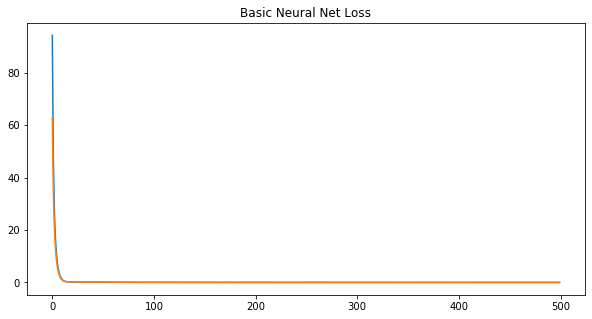

In [23]:
training_measures = history.history

loss = training_measures.get('loss')
training_loss = training_measures.get('val_loss')

epochs = range(500)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, training_loss, label='Validation Loss')
plt.title('Basic Neural Net Loss')
plt.show()

Nothing much to get from this, though I anticipate the model is heavily overfitting the training dataset

In [45]:
def create_model_mk2(input_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=156, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(loss=mean_squared_logarithmic_error, optimizer='adam')
    return model

model_mk2 = create_model_mk2(X_train_processed.shape[1])
model_mk2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 256)               40192     
_________________________________________________________________
dense_33 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_34 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_35 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 65        
Total params: 85,569
Trainable params: 85,569
Non-trainable params: 0
_________________________________________________________________


In [46]:
history = model_mk2.fit(X_train_processed, y_train, validation_split=0.3, epochs=300, verbose=0)

In [47]:
y_pred = model_mk2.predict(X_train_processed).flatten()